In [69]:
import pandas as pd
import numpy as np
import glob
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, classification_report, f1_score, accuracy_score


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

# Data Ingestion 

In [2]:
df = pd.read_csv("Interview_Mapping.csv")

In [3]:
df["Content"] = None
df.head()

,Judgements,Area.of.Law,Content
0,LNIND_1988_CAL_114,To be Tested,None
1,LNIND_1956_CAL_163,To be Tested,None
2,LNIND_1976_CAL_277,To be Tested,None
3,LNIND_1980_CAL_52,To be Tested,None
4,LNIND_1955_CAL_124,To be Tested,None


In [82]:
nlp = spacy.load("en",disable=(['ner', 'parser','tag','pos','shape']))
doc = nlp(str(contents))

In [79]:
path = "Fixed Judgements/"
nlp = spacy.load("en",disable=(['ner', 'parser']))

for file in glob.glob(path+"*.txt"):
    title = file.split(".")[0].split("/")[1]
    with open(file, 'rb') as f:
        contents = f.read()
    if title in df["Judgements"].values:
        doc = nlp(str(contents)) # lemmatization
        df.loc[df["Judgements"]==title,"Content"] = ' '.join([token.lemma_ for token in doc])
    else:
        print ("File not found in the mapping")
        continue

In [84]:
df_test = df[df["Area.of.Law"] == "To be Tested"]
df_train = df[df["Area.of.Law"] != "To be Tested"]

In [6]:
df_train["Content"].isna().sum()

0

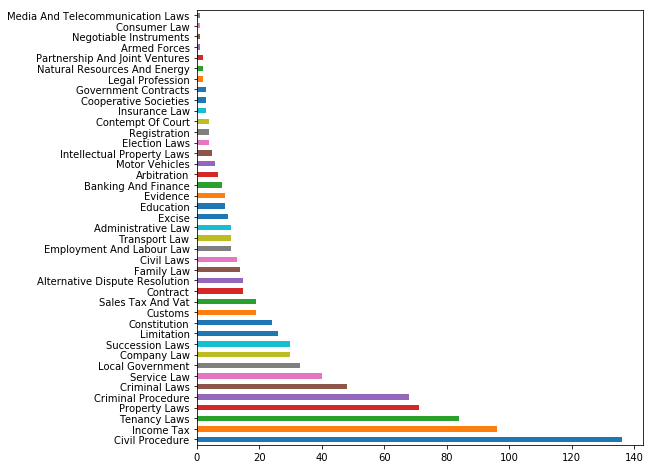

Civil Procedure                     136
Income Tax                           96
Tenancy Laws                         84
Property Laws                        71
Criminal Procedure                   68
Criminal Laws                        48
Service Law                          40
Local Government                     33
Company Law                          30
Succession Laws                      30
Limitation                           26
Constitution                         24
Customs                              19
Sales Tax And Vat                    19
Contract                             15
Alternative Dispute Resolution       15
Family Law                           14
Civil Laws                           13
Employment And Labour Law            11
Transport Law                        11
Administrative Law                   11
Excise                               10
Education                             9
Evidence                              9
Banking And Finance                   8


In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
df_train["Area.of.Law"].value_counts().plot.barh()
plt.show()
df_train["Area.of.Law"].value_counts()



We can see there is an imbalance issue here - some take 15% of all and some take only 0.1%. We could leave it as is if we care more about the majority class, but since this task is about prediction accuracy, we need to over sample the underrepresented classes so our model has enough changes to learn things from them, and use precision and recall rate to evaluate models.

In [86]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train["category"] = le.fit_transform(df_train["Area.of.Law"])

In [87]:
df_train.head()

,Judgements,Area.of.Law,Content,category
100,LNIND_1951_CAL_115,Criminal Laws,"b""\xe2\x80\x93 < kydishonestly receive steal p...",13
101,LNIND_1954_CAL_37,Property Laws,b'parties\nsatya kinkar dutt versus kiron chan...,34
102,LNIND_1954_CAL_72,Criminal Procedure,b'parties\nbholaram dalmia versus state\nhigh ...,14
103,LNIND_1953_CAL_151,Limitation,b'parties\nsri madan mohon jew versus bejoyaba...,27
104,LNIND_1980_CAL_65,Company Law,b'\n\nparties\nindian bank versus bengal potte...,7


In [88]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df_train["Content"]).toarray()
labels = df_train["category"]
features.shape

(899, 51030)

In [89]:
from sklearn.feature_selection import chi2
category_id_df = df_train[['Area.of.Law', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
N = 6
for title, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

    print("# '{}':".format(title))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'Administrative Law':
  . Most correlated unigrams:
. anti
. flour
. natural
. deep
. alignment
. rehabilitation
  . Most correlated bigrams:
. order serve
. unreasonable restriction
. principle natural
. hear person
. rule natural
. natural justice
  . Most correlated trigrams:
. demand justice pron
. pron pron opportunity
. make section act
. provide state government
. principle natural justice
. rule natural justice
# 'Alternative Dispute Resolution':
  . Most correlated unigrams:
. arbitrate
. award
. umpire
. arbitrators
. arbitration
. arbitrator
  . Most correlated bigrams:
. arbitration clause
. arbitrator appoint
. arbitrator pron
. arbitration proceeding
. arbitration act
. arbitration agreement
  . Most correlated trigrams:
. set aside award
. arbitration agreement party
. award set aside
. arbitration agreement pron
. party arbitration agreement
. arbitration act 1940
# 'Arbitration':
  . Most correlated unigrams:
. commerce
. chamber
. umpire
. sethia
. arbitration
. arb

# 'Excise':
  . Most correlated unigrams:
. glass
. hafiz
. excises
. fan
. elt
. excise
  . Most correlated bigrams:
. excise calcutta
. duty realise
. central excise
. excise duty
. collector central
. item 33
  . Most correlated trigrams:
. central excises salt
. central excise rules
. excises salt act
. assistant collector central
. central excise calcutta
. collector central excise
# 'Family Law':
  . Most correlated unigrams:
. desertion
. cruelty
. marriage
. matrimonial
. spouse
. divorce
  . Most correlated bigrams:
. special marriage
. dissolution marriage
. judicial separation
. decree divorce
. hindu marriage
. marriage act
  . Most correlated trigrams:
. decree dissolution marriage
. dissolution marriage ground
. divorce act 1869
. decree judicial separation
. special marriage act
. hindu marriage act
# 'Government Contracts':
  . Most correlated unigrams:
. jamal
. timber
. stall
. reserved
. 538
. mayor
  . Most correlated bigrams:
. contract agreement
. behalf governor


# 'Transport Law':
  . Most correlated unigrams:
. consignment
. carrier
. regional
. route
. carriage
. bus
  . Most correlated bigrams:
. loss destruction
. sub committee
. transport service
. contract carriage
. stage carriage
. transport authority
  . Most correlated trigrams:
. order date 27th
. pron rule make
. destruction deterioration good
. indian railways act
. notice undersection 77
. loss destruction deterioration


We see these keywords make sense - they're related to the category. After comparing 1-, 2- and 3-ngram results, 1-2 ngram seems enough to show the distinctions among categories.

# Preprocessing

In [90]:
# train test split
X = df_train["Content"]
y = df_train["category"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [181]:
# vectorize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

count_vect = CountVectorizer(ngram_range=(1,2),max_features = 1500, max_df = 0.5,stop_words = 'english')
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(674, 1500)

In [182]:
# tf transform
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(sublinear_tf = True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(674, 1500)

In [183]:
min_classes = pd.Series(y_train).value_counts().index[-15:].tolist()
min_require = np.repeat(10,15)
min_dict = dict(zip(min_classes,min_require))

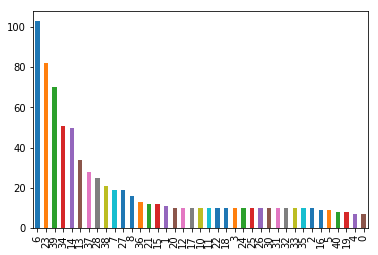

In [184]:
# Oversample the minority classes
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 0,sampling_strategy=min_dict)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)
X_train_resampled.shape
pd.Series(y_train_resampled).value_counts().plot.bar()

In [185]:
max_class = np.argmax(pd.Series(y_train_resampled).value_counts())

In [186]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0,sampling_strategy={max_class:400})

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

smote = SMOTE(random_state = 0,sampling_strategy="all")

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)



In [188]:
X_train_resampled.shape

(15600, 1500)

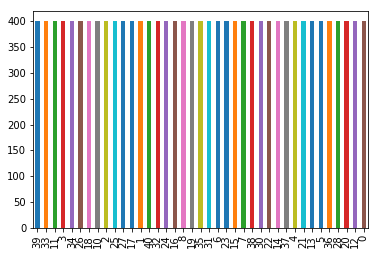

In [187]:
pd.Series(y_train_resampled).value_counts().plot.bar()

We are ready to train the model!

# Modeling

In [46]:
def train_model(clf, X_train_resampled, y_train_resampled, X_test_tfidf):
    # fit the training dataset on the classifier
    clf.fit(X_train_resampled, y_train_resampled)
    
    # predict the labels on validation dataset
    y_pred = clf.predict(X_test_tfidf)
    macro_f1 =  f1_score(y_test,y_pred,average = "macro")
    precision = precision_score(y_test,y_pred,average = "macro")
    acc = accuracy_score(y_test,y_pred)
    print(type(clf).__name__)
    print ('macro_f1', macro_f1, 'precision', precision,'accuracy', acc)    
    return clf
    

In [195]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


Benchmark performance of 4 models we want to try:

In [196]:
logreg = LogisticRegression()
logreg = train_model(logreg,X_train_tfidf, y_train, X_test_tfidf)

mnb = MultinomialNB()
mnb = train_model(mnb,X_train_tfidf, y_train, X_test_tfidf)

svm = SVC()
svm = train_model(svm,X_train_tfidf, y_train, X_test_tfidf)

rfc = RandomForestClassifier()
rfc = train_model(rfc,X_train_tfidf, y_train, X_test_tfidf)

LogisticRegression
macro_f1 0.22684144760388036 precision 0.3096303715698008 accuracy 0.5066666666666667
MultinomialNB
macro_f1 0.12170247518349608 precision 0.11814053851205557 accuracy 0.41333333333333333
SVC
macro_f1 0.007523939808481532 precision 0.004313725490196078 accuracy 0.14666666666666667
RandomForestClassifier
macro_f1 0.16383035545797384 precision 0.21100422625190424 accuracy 0.4177777777777778


The precision and f1 is pretty bad across, suggesting the need to use oversampled training data.

In [197]:
logreg = LogisticRegression()
logreg = train_model(logreg,X_train_resampled, y_train_resampled, X_test_tfidf)

mnb = MultinomialNB()
mnb = train_model(mnb,X_train_resampled, y_train_resampled, X_test_tfidf)

svm = SVC()
svm = train_model(svm,X_train_resampled, y_train_resampled, X_test_tfidf)

rfc = RandomForestClassifier(n_estimators = 100)
rfc = train_model(rfc,X_train_resampled, y_train_resampled, X_test_tfidf)

LogisticRegression
macro_f1 0.4176717791198222 precision 0.41260721034825415 accuracy 0.6533333333333333
MultinomialNB
macro_f1 0.3622519788101186 precision 0.3763332664067958 accuracy 0.6266666666666667
SVC
macro_f1 0.38049066176208085 precision 0.39533924626234773 accuracy 0.6266666666666667
RandomForestClassifier
macro_f1 0.29856299334550407 precision 0.3032761301401652 accuracy 0.5466666666666666


Definitely some improvement! Next, let's try tuning the hyperparameters for some promising models to see if we can improve the performance.

In [198]:
# Grid Search CV - log reg
logreg = LogisticRegression(n_jobs = -1)
param = {'C': [0.1, 0.01, 1, 10,20,30,40]}
cv = RandomizedSearchCV(logreg, param_distributions = param, scoring = "f1_macro",n_jobs = -1)
cv.fit(X_train_resampled,y_train_resampled)
#logreg = cv.best_estimator_
print (cv.best_params_)

logreg = train_model(cv,X_train_resampled, y_train_resampled, X_test_tfidf)


{'C': 20}
RandomizedSearchCV
macro_f1 0.4185814460982529 precision 0.42208204493918783 accuracy 0.6488888888888888


In [200]:
# Grid Search CV - random forest
param = {'n_estimators': [64, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,20,30,None],
        }
rfc = RandomForestClassifier()
cv = RandomizedSearchCV(rfc, param, scoring = "f1_macro",n_jobs = -1)
cv.fit(X_train_resampled,y_train_resampled)

print (cv.best_params_)
rfc = train_model(cv,X_train_resampled, y_train_resampled, X_test_tfidf)

{'n_estimators': 150, 'max_features': 'log2', 'max_depth': 30}
RandomizedSearchCV
macro_f1 0.27492361340560606 precision 0.3340132558952435 accuracy 0.52


In [205]:
# Grid Search CV - SGD
from sklearn.linear_model import SGDClassifier

param = {'penalty': ['l1','l2'],
         'alpha': [1, 0.1, 0.01, 0.001],
         'n_jobs': [-1]}  
sgd = SGDClassifier()
cv = RandomizedSearchCV(sgd, param, scoring = "f1_macro",n_jobs = -1)
cv.fit(X_train_resampled, y_train_resampled)

print (cv.best_params_)
sgd = train_model(sgd,X_train_resampled, y_train_resampled, X_test_tfidf)

{'penalty': 'l2', 'n_jobs': -1, 'alpha': 0.001}
SGDClassifier
macro_f1 0.38890977271886346 precision 0.39781488352916927 accuracy 0.6133333333333333


# Predicting

Lastly, we can use the best model so far to make prediction on the test data.

In [209]:
train_model(LogisticRegression(C=1, n_jobs = -1), X_train_resampled, y_train_resampled, X_test_tfidf)

LogisticRegression
macro_f1 0.4176717791198222 precision 0.41260721034825415 accuracy 0.6533333333333333


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
 # transform test data using existing transformers
test_X = df_test["Content"]
test_X_counts = count_vect.transform(test_X)
test_X_tfidf = tfidf_transformer.transform(test_X_counts)

In [212]:
# predict using the chosen model 
pred_y = cv.predict(test_X_tfidf)
print (pred_y)
# transform encoded y back to Areas of Law
label_y = le.inverse_transform(pred_y)

result_df = pd.DataFrame()
result_df["Judgements"] = df_test["Judgements"]
result_df["Prediction"] = label_y
#result_df.to_csv("Teija_Gui_results.csv")

[34 28  5 14 40  1  7 28 23 39 23 39 23 28 10 14 18 39 37 11 23 23 16  7
 39  6 23 20 39  8 36 39  7 23 34 14  1 11 28 15 16 18 13 36  5 34 14 38
 39 14 13 39 39 27  1 28  1 18  4  8 23 15 34 38 38 38 14 15 34  7 18 36
 27 11 37  8 23 13 15 36 34  7  1 39 20 39 38 37 36 23 39 23 23 14 27 16
 23 21 13  6]


In [213]:
result_df

,Judgements,Prediction
0,LNIND_1988_CAL_114,Property Laws
1,LNIND_1956_CAL_163,Local Government
2,LNIND_1976_CAL_277,Civil Laws
3,LNIND_1980_CAL_52,Criminal Procedure
4,LNIND_1955_CAL_124,Transport Law
5,LNIND_1954_CAL_3,Alternative Dispute Resolution
6,LNIND_1951_CAL_60,Company Law
7,LNIND_1954_CAL_46,Local Government
8,LNIND_1976_CAL_119,Income Tax
9,LNIND_1993_DEL_120,Tenancy Laws


# Further Readings

1. Howe, J. S. T., Khang, L. H., & Chai, I. E. (2019). Legal Area Classification: A Comparative Study of Text Classifiers on Singapore Supreme Court Judgments. arXiv preprint arXiv:1904.06470. https://arxiv.org/pdf/1904.06470.pdf

2. Sulea, O. M., Zampieri, M., Malmasi, S., Vela, M., Dinu, L. P., & Van Genabith, J. (2017). Exploring the use of text classification in the legal domain. arXiv preprint arXiv:1710.09306. https://arxiv.org/pdf/1710.09306.pdf